In [7]:
#Loading modules for model
from keras import backend as K
from keras import layers, Input
from keras import models
import keras
import numpy as np
import matplotlib.pyplot as plt
from  keras.preprocessing import image
from scipy.stats import norm

In [3]:
img_path ='/Users/duutabib/MATLAB/images_computer_vision/beach.jpeg'

img= image.load_img(img_path, target_size=(500, 500))
img =image.img_to_array(img)
img =np.expand_dims(img, axis=0)

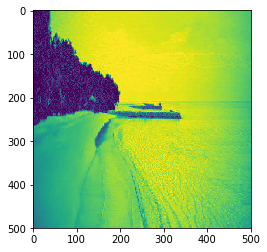

In [27]:
plt.imshow(img[0,:,:,2])
plt.show()

In [4]:
img_shape =(28, 28, 1)
batch_size = 16
latent_dim = 2


In [72]:
#we don't use the tradition definition since this allows for multi-input modules.
input_img =keras.Input(shape=img_shape)

x =layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_img)
x =layers.Conv2D(64, (3,3), padding='same', strides=(2,2), activation='relu')(x)
x =layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x =layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
shape_before_flattening=K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)  #thus is not clear to me at this time...a
z_log_var= layers.Dense(latent_dim)(x)

def sample_from_latent_space(args):
    z_mean, z_log_var = args
    x= K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=1)
    return x*K.exp(z_log_var) + z_mean 

z = layers.Lambda(sample_from_latent_space)([z_mean, z_log_var])

##decoder input : from the latent space to the images. 
decoder_input = layers.Input(K.int_shape(z)[1:])  # int_shape returne the shape of the arg.
x=layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x=layers.Reshape(shape_before_flattening[1:])(x)
x=layers.Conv2DTranspose(32, 3, padding="same", activation='relu', strides=(2,2))(x)  #deconv
x=layers.Conv2D(1,3, padding='same', activation='sigmoid')(x)
decoder_model = models.Model(decoder_input, x)
z_decoded =decoder_model(z)


class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded =K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 *K.mean(1+ z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    def call(self, inputs):
        x =inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y= CustomVariationalLayer()([input_img, z_decoded])    

In [73]:
#training the Vae
from keras.datasets import mnist

vae_model = models.Model(input_img, y)
vae_model.compile(optimizer='SGD', loss=None) 
vae_model.summary()

(x_train, _), (x_test, y_test ) = mnist.load_data()
#preprocess the data

x_train = x_train.astype('float32')/255.
x_train = x_train.reshape(x_train.shape + (1, ))
x_test = x_test.astype('float32')/255.
x_test = x_test.reshape(x_test.shape +(1,))

vae_model.fit(x= x_train, y=None, shuffle= True, epochs = 10, batch_size= batch_size, validation_data=(x_test, None))



/Users/duutabib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.
  """


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (

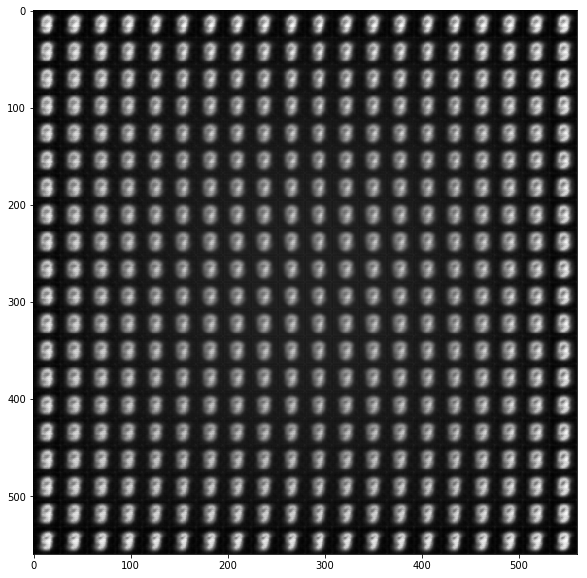

In [87]:
n = 20
digit_size =28
figure =np.zeros((digit_size * n , digit_size*n))
grid_x= norm.ppf(np.linspace(0.01, 0.99, n))
grid_y= norm.ppf(np.linspace(0.01, 0.99, n))

for i , yi in enumerate(grid_x):
    for j , xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder_model.predict(z_sample, batch_size=batch_size)
        digit= x_decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size: (i+1) * digit_size, j*digit_size: (j+1)*digit_size] = digit

plt.figure(figsize=(10, 10))    
plt.imshow(figure, cmap='Greys_r')
plt.show()

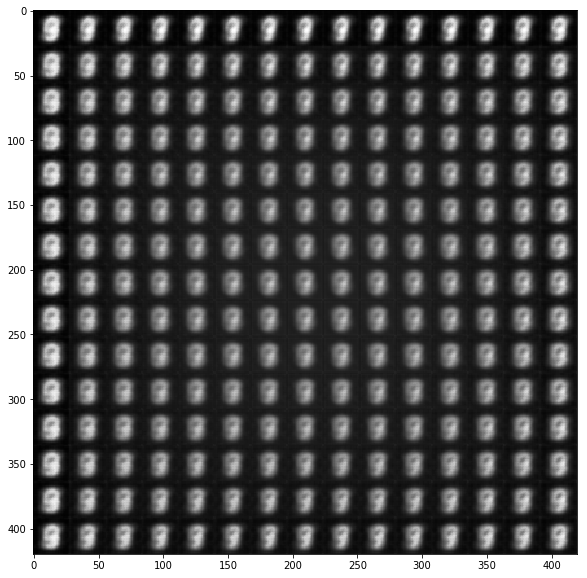

In [82]:
n = 20
digit_size =28
figure =np.zeros((digit_size * n , digit_size*n))
grid_x= norm.ppf(np.linspace(0.0015, 0.9566, n))
grid_y= norm.ppf(np.linspace(0.0015, 0.9566, n))

for i , yi in enumerate(grid_x):
    for j , xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder_model.predict(z_sample, batch_size=batch_size)
        digit= x_decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size: (i+1) * digit_size, j*digit_size: (j+1)*digit_size] = digit

plt.figure(figsize=(10, 10))    
plt.imshow(figure, cmap='Greys_r')
plt.show()

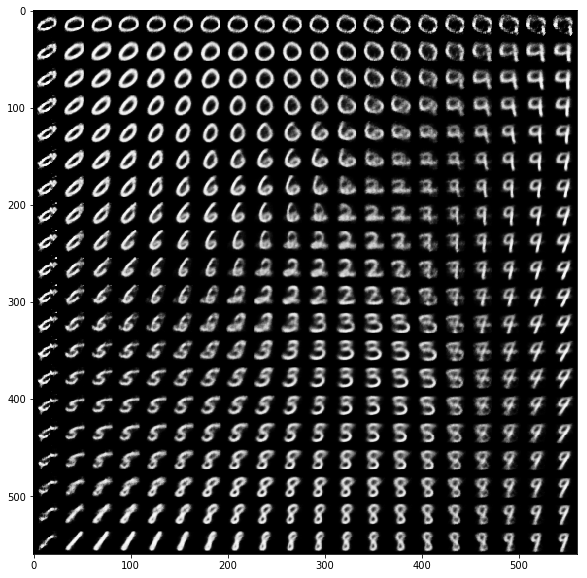

In [71]:
n = 20 
digit_size =28
figure =np.zeros((digit_size * n , digit_size*n))
grid_x= norm.ppf(np.linspace(0.0015, 0.9555, n))
grid_y= norm.ppf(np.linspace(0.0015, 0.9555, n))

for i , yi in enumerate(grid_x):
    for j , xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder_model.predict(z_sample, batch_size=batch_size)
        digit= x_decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size: (i+1) * digit_size, j*digit_size: (j+1)*digit_size] = digit

plt.figure(figsize=(10, 10))    
plt.imshow(figure, cmap='Greys_r')
plt.show()

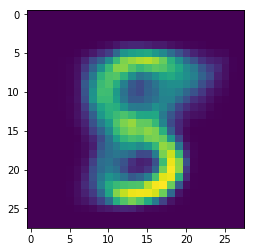

In [70]:
import random
s_sample=decoder_model.predict(np.array([[random.uniform(0,1),random.uniform(0.8,1)]]), batch_size=20)
plt.imshow(s_sample[0,:,:,0])
plt.show()

In [65]:
s_sample[0,:,:,0].shape

(28, 28)

In [49]:
random.uniform(0,1)

0.559435953626343

In [40]:
np.linspace((1))

TypeError: linspace() missing 1 required positional argument: 'stop'

In [88]:
x_train.shape

(60000, 28, 28, 1)